In [8]:
import numpy as np
import matplotlib.pyplot as plt

In [81]:
def vector_product(x, y):
    return x[:, 0]*y[:, 1] - x[:, 1]*y[:, 0]

def intersect(x1, d1, x2, d2):
    """
    Arguments:
    x1, d1, x2, d2: (n, 2)
    return: t, u s.t. x1 + t*d1 == 2 + u*d2
    """
    rs = vector_product(d1, d2)
    t = vector_product(x2 - x1, d2) / rs
    u = vector_product(x2 - x1, d1) / rs
    tu = np.stack([t, u], 1)
    tu = np.minimum(tu, 1.-tu)
    m = np.any(0 > tu, axis=1)
    tu[m] = 0.
    return tu

In [82]:
x1 = np.array([[0, 1]])
d1 = np.array([[2, -2]])
x2 = np.array([[0, 0]])
d2 = np.array([[1, 1]])

In [83]:
intersect(x1, d1, x2, d2)

array([[0.25, 0.5 ]])

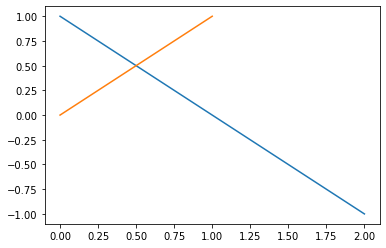

In [84]:
l1 = np.vstack([x1, x1+d1])
l2 = np.vstack([x2, x2+d2])
plt.plot(l1[:, 0], l1[:, 1])
plt.plot(l2[:, 0], l2[:, 1])